In [1]:
import pandas as pd
import random
import numpy as np
import sklearn as sk
from scipy import stats
import statistics
import cvxpy as cvx
import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
xgboost.__version__
from scipy.linalg import svd
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import math
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, wait
from deap import base, creator, tools, algorithms

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_name = "./german.data"

#read file
all_data = pd.read_csv(
  file_name,
  sep = ' ',
  header=None
)

all_data.columns = ['checking_acct', 'duration_month', 'credit_hist',
                    'purpose', 'credit_amount', 'savings', 'employ_years',
                    'install_as_percent_of_disp_income', 'married_and_sex',
                    'other_debtors', 'resident_since', 'property',
                    'age', 'other_installments', 'housing', 'existing_credits',
                    'job', 'num_liable', 'telephone', 'foreign', 'ground_truth']

# translate from codes to descriptive things
all_data.replace({"checking_acct": {'A11' : 1,
 'A12' : 2,
 'A13' : 3,
 'A14' : 0}}, inplace=True)

all_data.replace({"credit_hist": {'A30' : 0,
 'A31' : 1,
 'A32' : 2,
 'A33' : 3,
 'A34' : 4}}, inplace=True)

all_data.replace({"purpose": {
 'A40' : 0,
 'A41' : 1,
 'A42' : 2,
 'A43' : 3,
 'A44' : 4,
 'A45' : 5,
 'A46' : 6,
 'A47' : 7,
 'A48' : 8,
 'A49' : 9,
 'A410' : 10}}, inplace=True)

all_data.replace({"savings": {
 'A61' : 1,
 'A62' : 2,
 'A63' : 3,
 'A64' : 4,
 'A65' : 0}}, inplace=True)

all_data.replace({"employ_years": {
 'A71' : 0,
 'A72' : 1,
 'A73' : 2,
 'A74' : 3,
 'A75' : 4}}, inplace=True)

all_data.replace({"married_and_sex": {
 'A91' : 'male_div_sep',
 'A92' : 'female_div_sep_married',
 'A93' : 'male_single',
 'A94' : 'male_married_widowed',
 'A95' : 'female_single'}}, inplace=True)

all_data.replace({"other_debtors": {
 'A101' : 0,
 'A102' : 1,
 'A103' : 2}}, inplace=True)

all_data.replace({"property": {
 'A121' : 1,
 'A122' : 2,
 'A123' : 3,
 'A124' : 0}}, inplace=True)

all_data.replace({"other_installments": {
 'A141' : 1,
 'A142' : 2,
 'A143' : 0}}, inplace=True)

all_data.replace({"housing": {
 'A151' : 0,
 'A152' : 1,
 'A153' : 2}}, inplace=True)

all_data.replace({"job": {
 'A171' : 0,
 'A172' : 1,
 'A173' : 2,
 'A174' : 3}}, inplace=True)

all_data.replace({"telephone": {
 'A191' : 0,
 'A192' : 1}}, inplace=True)

all_data.replace({"foreign": {
 'A201' : 0,
 'A202' : 1}}, inplace=True)

all_data.replace({"ground_truth": {
 1 : 'accepted',
 2 : 'dennied'}}, inplace=True)


all_data.head()

,checking_acct,duration_month,credit_hist,purpose,credit_amount,savings,employ_years,install_as_percent_of_disp_income,married_and_sex,other_debtors,...,property,age,other_installments,housing,existing_credits,job,num_liable,telephone,foreign,ground_truth
0,1,6,4,3,1169,0,4,4,male_single,0,...,1,67,0,1,2,2,1,1,0,accepted
1,2,48,2,3,5951,1,2,2,female_div_sep_married,0,...,1,22,0,1,1,2,1,0,0,dennied
2,0,12,4,6,2096,1,3,2,male_single,0,...,1,49,0,1,1,1,2,0,0,accepted
3,1,42,2,2,7882,1,3,2,male_single,2,...,2,45,0,2,1,2,2,0,0,accepted
4,1,24,3,0,4870,1,2,3,male_single,0,...,0,53,0,2,2,2,2,0,0,dennied


In [3]:
learning_data = all_data.copy(deep=True)
features_to_transform = []

temp = pd.DataFrame()
temp['sex'] = learning_data['married_and_sex'].map(lambda x: x.split("_")[0])
dummies = pd.get_dummies(temp["sex"], prefix="sex")
learning_data = pd.concat([learning_data, dummies], axis=1)

for feature in features_to_transform:
    dummies = pd.get_dummies(learning_data[feature], prefix=feature)
    learning_data = pd.concat([learning_data, dummies], axis=1)
learning_data.head()

learning_data.columns = learning_data.columns.str.replace(' ', '_')
learning_data.columns = learning_data.columns.str.replace('-', '_')

learning_data['ground_truth_label'] = np.where(learning_data['ground_truth'] == 'accepted', 'accepted', 'dennied')
dummies = pd.get_dummies(learning_data['ground_truth_label'])
learning_data = pd.concat([learning_data, dummies] , axis = 1)
features_to_transform.append("ground_truth")
learning_data.drop(features_to_transform, axis=1, inplace=True)
learning_data.drop("married_and_sex", axis=1, inplace=True)
learning_data.head()
print(learning_data['num_liable'].max())

2


In [4]:
X_Labels = ['checking_acct', 'duration_month', 'credit_hist', 'purpose',
            'credit_amount', 'savings', 'employ_years',
            'install_as_percent_of_disp_income', 'other_debtors', 
            'resident_since', 'property', 'age', 'other_installments', 
            'housing', 'existing_credits','job', 'num_liable', 
            'telephone', 'foreign', 'sex_male']
Y_Labels = ['accepted']

X =  learning_data.loc[:, X_Labels]
Y =  learning_data.loc[:, Y_Labels]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =  0.2, random_state =  4)

# find and later remove linearly correlated pairs (not for xgboost but for LOCO later)
corr_thresh = .7
for column_a in X.columns:
    for column_b in X.columns:
        if column_a is not column_b:
            if X[column_a].corr(X[column_b]) > corr_thresh:
                print(str(column_a) + " " + str(column_b))
    

xgb_full = xgboost.DMatrix(X, label=Y)
xgb_train =  xgboost.DMatrix(X_train, label = Y_train)
xgb_test = xgboost.DMatrix(X_test, label = Y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.0002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "tree_method": 'gpu_hist',
    "subsample": 0.35
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params, xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
learning_data['pred'] = model.predict(xgb_full)

[0]	test-auc:0.63685
[1000]	test-auc:0.77161
[2000]	test-auc:0.77581
[3000]	test-auc:0.77882
[4000]	test-auc:0.78243
[5000]	test-auc:0.78639
[6000]	test-auc:0.78820
[7000]	test-auc:0.79036
[8000]	test-auc:0.79445
[9000]	test-auc:0.79649
[9999]	test-auc:0.79829


In [5]:
plt.hist(learning_data['pred'], bins = 20)
plt.show() 

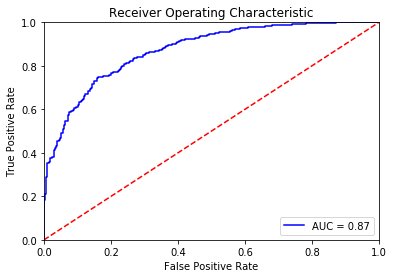

Optimal Threshold obtained using difference of TPR and FPR 0.65708095


In [6]:
%matplotlib inline
fpr, tpr , thresholds = roc_curve(learning_data['accepted'], learning_data['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
learning_data['y_pred'] = np.where(learning_data['pred'] > optimal_threshold, 1, 0)

## Find Burden

In [7]:
def d(indiv, other, cat, con, madArray, pred_func, columns=X_Labels):    
    dfm = pd.DataFrame([indiv, other], columns=columns)    
    preds = pred_func(xgboost.DMatrix(dfm))
    
    if preds.round().sum() != 1:
        return -1,
    
    ncat = len(cat)
    ncon = len(con)
            
    # MAD normalized L1 Norm
    normedl1norm = 0
    for index in con:
        mad = madArray[index]
        normedl1norm += abs(indiv[index] - other[index]) / mad

        
    # simpMat
    # both pos
    npindiv = np.array(indiv).astype(int)[cat]
    npother = np.array(other).astype(int)[cat]
        
    PosMat = npindiv & npother 
    NegMat = (1 - npindiv) & (1 - npother)
    total = npother.shape[0]
    dist = 1-((PosMat.sum() + NegMat.sum())/total)
        
    n = ncat + ncon
    return (1/(ncon*normedl1norm/n + ncat*dist/n),)

In [9]:
b = {
    'checking_acct':   ("catagorical", 4), 
    'duration_month':   ("continous", 80), 
    'credit_hist':   ("catagorical", 5), 
    'purpose':   ("catagorical", 11),
    'credit_amount':   ("continous", 50000), 
    'savings':   ("catagorical", 5), 
    'employ_years':   ("catagorical", 5),
    'install_as_percent_of_disp_income':   ("continous", 50), 
    'other_debtors':   ("catagorical", 3), 
    'resident_since':   ("continous", 6), 
    'property':   ("catagorical", 4), 
    'age':   ("continous", 100), 
    'other_installments':   ("catagorical", 3), 
    'housing':   ("catagorical", 3), 
    'existing_credits':   ("continous", 8),
    'job':   ("catagorical", 4), 
    'num_liable':   ("continous", 4), 
    'telephone':   ("catagorical", 2), 
    'foreign':   ("catagorical", 2), 
    'sex_male':   ("catagorical", 2)
}
ordered_cols = X_Labels

madArr = [0] * len(ordered_cols)
for feature in ordered_cols:
    bounds = b[feature]
    if bounds[0].startswith("cont"):
        madArr[ordered_cols.index(feature)] = learning_data.loc[:, feature].mad()


cat_list = []
con_list = []

for feature in ordered_cols:
    if b[feature][0].startswith('cata'):
        cat_list.append(ordered_cols.index(feature))
    else:
        con_list.append(ordered_cols.index(feature))

def create_bound_func_arr():
    ret = [0] * len(X_Labels)
    for i in cat_list:
        ret[i] = toolbox.cata_2_var
    for i in con_list:
        ret[i] = toolbox.con_var
    return ret

def create_indiv():
    ret = [0] * len(X_Labels)
    for i in cat_list:
        ret[i] = toolbox.cata_2_var()
    for i in con_list:
        ret[i] = toolbox.con_var()
    return creator.Individual(ret)

def mutate(indiv, func_arr, prob_mut):
    for i in range(len(indiv)):
        if(random.random() <= prob_mut):
            indiv[i] = func_arr[i]()
    return indiv,

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("cata_2_var", random.randint, 0, 1)
toolbox.register("con_var", random.uniform, 0, 100)

toolbox.register("individual", create_indiv)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, func_arr=create_bound_func_arr(), prob_mut=.5)
toolbox.register("select", tools.selTournament, tournsize=3)

In [11]:
burden_data = learning_data.copy()
burden_data = burden_data.loc[:,X_Labels]

c_facts = []

pop_size = len(X_Labels)**2
gens = 500

for i in range(burden_data.shape[0]):
    
    iper = burden_data.iloc[i].values.tolist()
    toolbox.register("evaluate", d, other=iper, cat=cat_list, con=con_list, madArray=madArr, pred_func=model.predict)

    
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=gens, halloffame=hof, verbose=False)

    print(str(i), ": Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    
    cfact_final = list(hof[0])
    cfact_final.append(hof[0].fitness.values[0])
        
    c_facts.append(cfact_final)
        
    toolbox.unregister("evaluate")

c_facts_df = pd.DataFrame(c_facts, columns=X_Labels+['fitness'], 
                          index=burden_data.index)
print(c_facts_df.shape)
c_facts_df.head()

0 : Best individual is: [1, 6.805291771994426, 0, 1, 99.35178382973014, 0, 0, 4.618877654356213, 0, 3.8780532167342674, 0, 67.33731253785876, 0, 1, 2.0966114708909744, 0, 1.2984569439349447, 1, 0, 1]
with fitness: (0.9977755818108209,)
1 : Best individual is: [0, 47.724634105388795, 0, 1, 96.46801109526812, 1, 0, 1.9234142737745374, 0, 1.9866861649358691, 1, 22.693486130129326, 0, 1, 1.0133352580364852, 0, 1.049566038936589, 0, 0, 0]
with fitness: (0.8737974430985032,)
2 : Best individual is: [1, 12.464207054664966, 0, 0, 93.50191373058391, 1, 1, 1.6958376654820584, 0, 3.308382662189191, 1, 49.398408892061354, 0, 1, 0.7919720218467985, 1, 2.0545146306333084, 0, 0, 1]
with fitness: (1.170008540290817,)
3 : Best individual is: [0, 41.664507938352045, 0, 0, 88.62458044829954, 1, 1, 2.11814390182391, 0, 3.7945079651086067, 0, 45.033790868145985, 0, 0, 0.7884122654940318, 0, 1.9704482983776028, 0, 0, 1]
with fitness: (0.5909312734899045,)
4 : Best individual is: [0, 23.949315850311326, 1, 0

KeyboardInterrupt: 

In [ ]:
burden_data['fitness'] = c_facts_df.fitness
burden_data['dist'] = 1/c_facts_df.fitness

burden_data.head()

In [ ]:
print(burden_data.groupby('sex_male', as_index=False)[['fitness','dist']].mean())


In [ ]:
from datetime import datetime

c_facts_df.to_csv("./germanCred_cfact_" + datetime.now().strftime("%m_%d_%Y_%H_%M") +".csv")

In [ ]:
from collections import namedtuple

class Model:
    
    def __init__(self, datadf, cfdf):
        self.pred = datadf['pred'].copy()
        self.label = datadf['Low'].copy()
        self.datadf = datadf.copy()
        self.cfdf = cfdf.copy()
        self.datadf['cfact_dist'] = 1/cfdf['fitness']
        self.datadf = self.datadf.query("cfact_dist == cfact_dist")
                    
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def get_burden(self):
        return self.datadf['cfact_dist'].mean()

    def burden_eq_opp(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        print(1-sp2p, sn2p, 1-op2p, on2p, "pburden")
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "other":
            priv_df = self.datadf.copy()
            disa_df = othr.datadf.copy()
            priv_n2p = sn2p[0]
            disa_n2p = on2p[0]
        else:
            priv_df = othr.datadf.copy()
            disa_df = self.datadf.copy()
            priv_n2p = on2p[0]
            disa_n2p = sn2p[0]
                
        priv_neg = priv_df[priv_df['y_pred'] == 0]
        disa_neg = disa_df[disa_df['y_pred'] == 0]
                
        num_priv_n2p = int(priv_n2p * priv_df.shape[0]) 
        priv_ind = np.asarray(priv_neg.sort_values('cfact_dist', ascending = True).id)[:num_priv_n2p]     
        num_disa_n2p = int(disa_n2p * disa_df.shape[0]) 
        disa_ind = np.asarray(disa_neg.sort_values('cfact_dist', ascending = True).id)[:num_disa_n2p]


        priv_df.loc[priv_ind, "pred"] = 1 - priv_df.loc[priv_ind, "pred"]
        disa_df.loc[disa_ind, "pred"] = 1 - disa_df.loc[disa_ind, "pred"]
        
        fair_self = None
        fair_othr = None
                
        if burdened_predictor is "other":
            fair_self = Model(priv_df, self.cfdf)
            fair_othr = Model(disa_df, othr.cfdf)
        else:
            fair_self = Model(disa_df, self.cfdf)
            fair_othr = Model(priv_df, othr.cfdf)
                            
        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
    
    def burden_eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        print(1-sp2p, sn2p, 1-op2p, on2p, "burden")
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "self":
            priv_df = self.datadf
            disa_df = othr.datadf
        else:
            priv_df = othr.datadf
            disa_df = self.datadf
        
        self_df = self.datadf.copy(deep=True)
        self_df_pos = self_df[self_df["y_pred"] == 1]
        self_df_neg = self_df[self_df["y_pred"] == 0]
        othr_df = othr.datadf.copy(deep=True)
        othr_df_pos = othr_df[othr_df["y_pred"] == 1]
        othr_df_neg = othr_df[othr_df["y_pred"] == 0]
    
            
        num_sn2p = int(self_df.shape[0] *  (sn2p[0]))
        sn2p_indices = np.asarray(self_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_sn2p]
        
        num_on2p = int(othr_df.shape[0] *  (on2p[0]))
        on2p_indices = np.asarray(othr_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_on2p]
        
        num_sp2n = int(self_df.shape[0] *  (1 - sp2p[0]))
        sp2n_indices = np.asarray(self_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_sp2n]
        
        num_op2n = int(othr_df.shape[0] *  (1 - op2p[0]))
        op2n_indices = np.asarray(othr_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_op2n]
        
        # flip those values
        self_df.loc[sn2p_indices, 'pred'] = 1 - self_df.loc[sn2p_indices, 'pred']      
        self_df.loc[sp2n_indices, 'pred'] = 1 - self_df.loc[sp2n_indices, 'pred']      

        othr_df.loc[on2p_indices, 'pred'] = 1 - othr_df.loc[on2p_indices, 'pred']
        othr_df.loc[op2n_indices, 'pred'] = 1 - othr_df.loc[op2n_indices, 'pred']      
        
        fair_self = Model(self_df, self.cfdf)
        fair_othr = Model(othr_df, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
        
    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
        
        # select random indices to flip in our model
        self_fair_pred = self.datadf.copy()
        self_pp_indices = self_fair_pred[self_fair_pred["pred"] >= .5]
        self_pn_indices = self_fair_pred[self_fair_pred["pred"] < .5]
        self_pp_indices = self_pp_indices.sample(frac=(1-sp2p[0]))
        self_pn_indices = self_pn_indices.sample(frac=sn2p[0])
        
        # flip randomly the predictions in our model
        self_fair_pred.loc[self_pn_indices.id] = 1 - self_fair_pred.loc[self_pn_indices.id]
        self_fair_pred.loc[self_pp_indices.id] = 1 - self_fair_pred.loc[self_pp_indices.id]

        # select random indices to flip in the other model
        othr_fair_pred = othr.datadf.copy()
        othr_pp_indices = othr_fair_pred[othr_fair_pred["pred"] >= .5]
        othr_pn_indices = othr_fair_pred[othr_fair_pred["pred"] < .5]
        othr_pp_indices = othr_pp_indices.sample(frac=(1-op2p[0]))
        othr_pn_indices = othr_pn_indices.sample(frac=on2p[0])

        # dlip randomly the precitions of the other model
        othr_fair_pred.loc[othr_pn_indices.id] = 1 - othr_fair_pred.loc[othr_pn_indices.id]
        othr_fair_pred.loc[othr_pp_indices.id] = 1 - othr_fair_pred.loc[othr_pp_indices.id]

        # create new model objects with the now fair predictions
        
        fair_self = Model(self_fair_pred, self.cfdf)
        fair_othr = Model(othr_fair_pred, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr   
        
        
    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def distance(self, othr):
        x = (self.fpr() - othr.fpr()) ** 2
        y = (self.tpr() - othr.tpr()) ** 2
        return math.sqrt(x + y)
    
    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [8]:
c_facts_df = pd.read_pickle("./compas_cfact_10_26_2020_10_05.pkle")    
c_facts_df = pd.concat([row for row in c_facts_df])
c_facts_df.index = learning_data.index
c_facts_df.head()

,sex_Male,sex_Female,age,race_African_American,race_Caucasian,priors_count,juv_fel_count,c_charge_degree_F,c_charge_degree_M,prediction,fitness
id,,,,,,,,,,,
3,1,0,33.505392,0,0,11.916809,0.211394,1,0,0.0,0.432431
4,1,1,2.007171,0,1,0.995421,0.200049,1,1,1.0,0.544474
8,1,0,55.304674,0,1,13.738700,0.288624,0,0,1.0,0.529226
10,0,1,44.325071,0,1,14.926775,0.100293,1,0,0.0,0.426456
14,0,0,25.886694,0,0,27.805292,0.264722,1,1,0.0,0.264016


In [16]:
burden_data_df = learning_data.copy()
burden_data_df['fitness'] = c_facts_df.fitness
burden_data_df['id'] = burden_data_df.index

aa_df = burden_data_df.loc[:, X_Labels+['y_pred', 'pred', 'id']+Y_Labels][burden_data_df['race_African_American']  == 1]
c_df = burden_data_df.loc[:, X_Labels+['y_pred', 'pred', 'id']+Y_Labels][burden_data_df['race_African_American']  == 0]

aa_m = Model(aa_df, c_facts_df.loc[aa_df.index])
c_m = Model(c_df, c_facts_df.loc[c_df.index])

bf_aa_m, bf_c_m, _ = aa_m.burden_eq_odds(c_m)
rf_aa_m, rf_c_m, _ = aa_m.eq_odds(c_m)
p_bf_aa_m, p_bf_c_m, _ = aa_m.burden_eq_opp(c_m)

print("African American Burden: ", aa_m.get_burden())
print("Caucasian Burden: ", c_m.get_burden())

print("African American")
print("before", "\n", aa_m)
print("burden", "\n", bf_aa_m)
print("random", "\n", rf_aa_m)
print("partial", "\n", p_bf_aa_m)
print()
print("Caucasian")
print("before", "\n", c_m)
print("burden", "\n", bf_c_m)
print("random", "\n", rf_c_m)
print("partial", "\n", p_bf_c_m)
print()

burden_data_df.head()

[1.10129794e-10] [0.23675743] [0.24961273] [1.34210121e-10] burden
[1.10129794e-10] [0.23675743] [0.24961273] [1.34210121e-10] pburden
African American Burden:  2.205133151037688
Caucasian Burden:  2.603702326611293
African American
before 
 Accuracy:	0.751
F.P. cost:	0.283
F.N. cost:	0.393
Base rate:	0.424
Avg. score:	0.420
burden 
 Accuracy:	0.626
F.P. cost:	0.460
F.N. cost:	0.352
Base rate:	0.424
Avg. score:	0.540
random 
 Accuracy:	0.751
F.P. cost:	0.324
F.N. cost:	0.335
Base rate:	0.500
Avg. score:	0.494
partial 
 Accuracy:	0.626
F.P. cost:	0.460
F.N. cost:	0.352
Base rate:	0.424
Avg. score:	0.540

Caucasian
before 
 Accuracy:	0.789
F.P. cost:	0.443
F.N. cost:	0.230
Base rate:	0.669
Avg. score:	0.662
burden 
 Accuracy:	0.641
F.P. cost:	0.385
F.N. cost:	0.404
Base rate:	0.669
Avg. score:	0.526
random 
 Accuracy:	0.789
F.P. cost:	0.334
F.N. cost:	0.275
Base rate:	0.568
Avg. score:	0.557
partial 
 Accuracy:	0.789
F.P. cost:	0.443
F.N. cost:	0.230
Base rate:	0.669
Avg. score:	0.662



,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,...,race_Caucasian,c_charge_degree_F,c_charge_degree_M,score_factor,Low,MediumHigh,pred,y_pred,fitness,id
id,,,,,,,,,,,,,,,,,,,,,
3,Male,34,25 - 45,African-American,0,0,F,1,3,1,...,0,1,0,Low,1,0,0.675747,1,0.432431,3
4,Male,24,Less than 25,African-American,0,4,F,1,4,1,...,0,1,0,Low,1,0,0.141532,0,0.544474,4
8,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,...,1,1,0,MediumHigh,0,1,0.246823,0,0.529226,8
10,Female,39,25 - 45,Caucasian,0,0,M,0,1,0,...,1,0,1,Low,1,0,0.888087,1,0.426456,10
14,Male,27,25 - 45,Caucasian,0,0,F,0,4,0,...,1,1,0,Low,1,0,0.685740,1,0.264016,14


In [17]:
b_agg_fair = pd.concat([bf_aa_m.datadf, bf_c_m.datadf])
b_agg_fair['is_recid'] = learning_data.loc[b_agg_fair.index, 'is_recid']
pb_agg_fair = pd.concat([p_bf_aa_m.datadf, p_bf_c_m.datadf])
pb_agg_fair['is_recid'] = learning_data.loc[pb_agg_fair.index, 'is_recid']
r_agg_fair = pd.concat([rf_aa_m.datadf, rf_c_m.datadf])
r_agg_fair['is_recid'] = learning_data.loc[r_agg_fair.index, 'is_recid']


print("original model's accuracy relative to ground truth")
print(learning_data[learning_data['y_pred'] == 1][learning_data['is_recid'] == 0].shape[0]/learning_data.shape[0])
print("burden based derived predictor's accuracy relative to ground truth")
print(b_agg_fair[b_agg_fair['pred'] >= .5][b_agg_fair['is_recid'] == 0].shape[0]/b_agg_fair.shape[0])
print("partial burden based derived predictor's accuracy relative to ground truth")
print(pb_agg_fair[pb_agg_fair['pred'] >= .5][pb_agg_fair['is_recid'] == 0].shape[0]/pb_agg_fair.shape[0])
print("random derived predictor's accuracy relative to ground truth")
print(r_agg_fair[r_agg_fair['pred'] >= .5][r_agg_fair['is_recid'] == 0].shape[0]/r_agg_fair.shape[0])


original model's accuracy relative to ground truth
0.3643425539977264
burden based derived predictor's accuracy relative to ground truth
0.35013262599469497
partial burden based derived predictor's accuracy relative to ground truth
0.4109511178476696
random derived predictor's accuracy relative to ground truth
0.3440697233800682


### Demographic parity

random demo parity
0.5582501
0.58456695

burden demo parity
0.49453163
0.687874

partial burden demo parity
0.7436995
0.687874

none demo parity
0.7436995
0.45574802



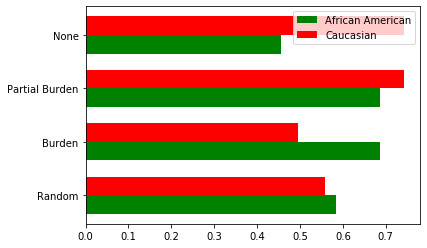

In [47]:
rf_aa_dp = rf_aa_m.datadf['pred'].round().mean() 
rf_c_dp  = rf_c_m.datadf['pred'].round().mean()

bf_aa_dp = bf_aa_m.datadf['pred'].round().mean()
bf_c_dp  = bf_c_m.datadf['pred'].round().mean()

aa_dp = aa_m.datadf['pred'].round().mean()
c_dp  = c_m.datadf['pred'].round().mean()

p_bf_aa_dp = p_bf_aa_m.datadf['pred'].round().mean()
p_bf_c_dp  = p_bf_c_m.datadf['pred'].round().mean()


print("random demo parity")
print(rf_c_dp)
print(rf_aa_dp)
print()

print("burden demo parity")
print(bf_c_dp)
print(bf_aa_dp)
print()

print("partial burden demo parity")
print(p_bf_c_dp)
print(p_bf_aa_dp)
print()

print("none demo parity")
print(c_dp)
print(aa_dp)
print()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
aa_dps = [rf_aa_dp,
         bf_aa_dp,
         p_bf_aa_dp,
         aa_dp]
c_dps  = [rf_c_dp,
         bf_c_dp,
         p_bf_c_dp,
         c_dp]
ind = np.arange(4)
width = .35
ax.barh(ind, aa_dps, width, color='g', label='African American')
ax.barh(ind+width, c_dps, width, color='r', label='Caucasian')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(('Random', 'Burden', 'Partial Burden', 'None'))
ax.legend()
plt.show()

### equ. odds and opp

Pr{^Y= 1|A= 0,Y= 1}= Pr{^Y= 1|A= 1,Y= 1} is opp

random eq opp
0.8058577
0.83553874

burden eq opp
0.6012793
0.86998516

partial burden eq opp
0.8983653
0.86998516

default eq opp
0.8983653
0.743685



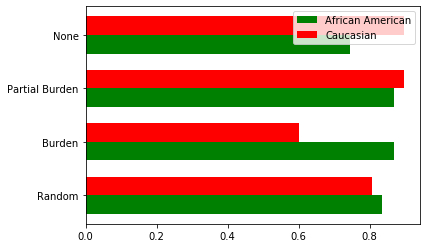

In [48]:
rf_aa_eqop = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eqop  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()

bf_aa_eqop = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eqop  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()

p_bf_aa_eqop = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eqop  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()

aa_eqop = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eqop  = c_m.datadf.query("Low == 1")['pred'].round().mean()

print("random eq opp")
print(rf_c_eqop)
print(rf_aa_eqop)
print()

print("burden eq opp")
print(bf_c_eqop)
print(bf_aa_eqop)
print()

print("partial burden eq opp")
print(p_bf_c_eqop)
print(p_bf_aa_eqop)
print()

print("default eq opp")
print(c_eqop)
print(aa_eqop)
print()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
aa_dps = [rf_aa_eqop,
         bf_aa_eqop,
         p_bf_aa_eqop,
         aa_eqop]
c_dps  = [rf_c_eqop,
         bf_c_eqop,
         p_bf_c_eqop,
         c_eqop]
ind = np.arange(4)
width = .35
ax.barh(ind, aa_dps, width, color='g', label='African American')
ax.barh(ind+width, c_dps, width, color='r', label='Caucasian')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(('Random', 'Burden', 'Partial Burden', 'None'))
ax.legend()
plt.show()

random eq odds
given y = 0
0.23237886
0.33375314
delta:  -0.10137428
given y = 1
0.8058577
0.83553874
delta:  -0.029681027

burden eq odds
given y = 0
0.27873564
0.5538546
delta:  -0.27511895
given y = 1
0.6012793
0.86998516
delta:  -0.26870584

partial burden eq odds
given y = 0
0.43103448
0.5538546
delta:  -0.12282011
given y = 1
0.8983653
0.86998516
delta:  0.028380156

default eq odds
given y = 0
0.43103448
0.2438491
delta:  0.18718538
given y = 1
0.8983653
0.743685
delta:  0.15468031



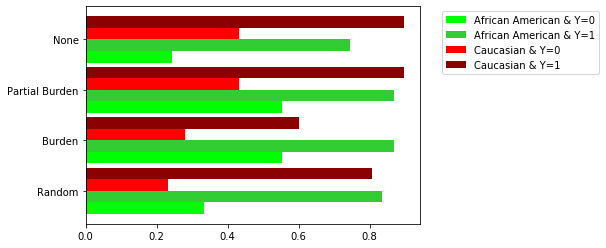

In [52]:
rf_aa_eq1 = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eq1  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()
rf_aa_eq0 = rf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
rf_c_eq0  = rf_c_m.datadf.query("Low == 0")['pred'].round().mean()


bf_aa_eq1 = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eq1  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
bf_aa_eq0 = bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
bf_c_eq0  = bf_c_m.datadf.query("Low == 0")['pred'].round().mean()

p_bf_aa_eq1 = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eq1  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_aa_eq0 = p_bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
p_bf_c_eq0  = p_bf_c_m.datadf.query("Low == 0")['pred'].round().mean()


aa_eq1 = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eq1  = c_m.datadf.query("Low == 1")['pred'].round().mean()
aa_eq0 = aa_m.datadf.query("Low == 0")['pred'].round().mean()
c_eq0  = c_m.datadf.query("Low == 0")['pred'].round().mean()


print("random eq odds")
print("given y = 0")
print(rf_c_eq0)
print(rf_aa_eq0)
print("delta: ", rf_c_eq0-rf_aa_eq0)
print("given y = 1")
print(rf_c_eq1)
print(rf_aa_eq1)
print("delta: ", rf_c_eq1-rf_aa_eq1)
print()

print("burden eq odds")
print("given y = 0")
print(bf_c_eq0)
print(bf_aa_eq0)
print("delta: ", bf_c_eq0-bf_aa_eq0)
print("given y = 1")
print(bf_c_eq1)
print(bf_aa_eq1)
print("delta: ", bf_c_eq1-bf_aa_eq1)
print()

print("partial burden eq odds")
print("given y = 0")
print(p_bf_c_eq0)
print(p_bf_aa_eq0)
print("delta: ", p_bf_c_eq0-p_bf_aa_eq0)
print("given y = 1")
print(p_bf_c_eq1)
print(p_bf_aa_eq1)
print("delta: ", p_bf_c_eq1-p_bf_aa_eq1)
print()

print("default eq odds")
print("given y = 0")
print(c_eq0)
print(aa_eq0)
print("delta: ", c_eq0-aa_eq0)
print("given y = 1")
print(c_eq1)
print(aa_eq1)
print("delta: ", c_eq1-aa_eq1)
print()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
aa_dps_0 = [rf_aa_eq0,
         bf_aa_eq0,
         p_bf_aa_eq0,
         aa_eq0]
c_dps_0  = [rf_c_eq0,
         bf_c_eq0,
         p_bf_c_eq0,
         c_eq0]
aa_dps_1 = [rf_aa_eq1,
         bf_aa_eq1,
         p_bf_aa_eq1,
         aa_eq1]
c_dps_1  = [rf_c_eq1,
         bf_c_eq1,
         p_bf_c_eq1,
         c_eq1]

ind = np.arange(4)
width = .23
ax.barh(ind, aa_dps_0, width, color='lime', label='African American & Y=0')
ax.barh(ind+width, aa_dps_1, width, color='limegreen', label='African American & Y=1')
ax.barh(ind+(width*2), c_dps_0, width, color='red', label='Caucasian & Y=0')
ax.barh(ind+(width*3), c_dps_1, width, color='darkred', label='Caucasian & Y=1')
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_yticks((ind + (width*3/2)))
ax.set_yticklabels(('Random', 'Burden', 'Partial Burden', 'None'))

plt.show()

In [30]:
rf_aa_eq1 = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eq1  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()
rf_aa_eq0 = rf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
rf_c_eq0  = rf_c_m.datadf.query("Low == 0")['pred'].round().mean()


bf_aa_eq1 = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eq1  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
bf_aa_eq0 = bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
bf_c_eq0  = bf_c_m.datadf.query("Low == 0")['pred'].round().mean()

p_bf_aa_eq1 = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eq1  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_aa_eq0 = p_bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
p_bf_c_eq0  = p_bf_c_m.datadf.query("Low == 0")['pred'].round().mean()


aa_eq1 = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eq1  = c_m.datadf.query("Low == 1")['pred'].round().mean()
aa_eq0 = aa_m.datadf.query("Low == 0")['pred'].round().mean()
c_eq0  = c_m.datadf.query("Low == 0")['pred'].round().mean()


print("random eq odds")
print("given y = 0")
print(rf_c_eq0)
print(rf_aa_eq0)
print("delta: ", rf_c_eq0-rf_aa_eq0)
print("given y = 1")
print(rf_c_eq1)
print(rf_aa_eq1)
print("delta: ", rf_c_eq1-rf_aa_eq1)
print()

print("burden eq odds")
print("given y = 0")
print(bf_c_eq0)
print(bf_aa_eq0)
print("delta: ", bf_c_eq0-bf_aa_eq0)
print("given y = 1")
print(bf_c_eq1)
print(bf_aa_eq1)
print("delta: ", bf_c_eq1-bf_aa_eq1)
print()

print("partial burden eq odds")
print("given y = 0")
print(p_bf_c_eq0)
print(p_bf_aa_eq0)
print("delta: ", p_bf_c_eq0-p_bf_aa_eq0)
print("given y = 1")
print(p_bf_c_eq1)
print(p_bf_aa_eq1)
print("delta: ", p_bf_c_eq1-p_bf_aa_eq1)
print()

print("default eq odds")
print("given y = 0")
print(c_eq0)
print(aa_eq0)
print("delta: ", c_eq0-aa_eq0)
print("given y = 1")
print(c_eq1)
print(aa_eq1)
print("delta: ", c_eq1-aa_eq1)
print()

random eq odds
given y = 0
0.23237886
0.33375314
delta:  -0.10137428
given y = 1
0.8058577
0.83553874
delta:  -0.029681027

burden eq odds
given y = 0
0.23132184
0.5215965
delta:  -0.29027465
given y = 1
0.62473345
0.8751857
delta:  -0.25045228

partial burden eq odds
given y = 0
0.43103448
0.2438491
delta:  0.18718538
given y = 1
0.8983653
0.743685
delta:  0.15468031

default eq odds
given y = 0
0.43103448
0.2438491
delta:  0.18718538
given y = 1
0.8983653
0.743685
delta:  0.15468031

